In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
# test with csv
mat1 = pd.read_csv('datasets-b3/APER3.csv')
mat2 = pd.read_csv('datasets-b3/BEES3.csv')

In [ ]:
var = []
var.append(('BEES3', 'BEES3', 0.555))
var.append(('BEES3', 'BEES3', 0.555))
var.append(('BEES3', 'BEES3', 0.555))
var.append(('BEES3', 'BEES3', 0.555))
var

In [ ]:
type(var)
type(var[0])

In [ ]:
var2 = {}

In [ ]:
type(var2)

In [ ]:
data = pd.read_csv('datasets/data.csv', index_col=0)
data

In [ ]:
rows = []
rows.append(["ABC","CDE",0.56663])
rows.append(["ABC","CDE",0.56663])

df = pd.DataFrame(rows, columns=['A', 'B', 'C'])
df

In [ ]:
len(rows)

In [ ]:
data = pd.read_csv('datasets/data.csv', index_col=0)


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split


# In[1]:


#check cointegration status
def cointegration(data1,data2):
    
    #train test split 
    df1,test1,df2,test2=train_test_split(data1,data2,test_size=0.7
                                         ,shuffle=False)
    
    train=pd.DataFrame()
    train['asset1']=df1['Close']
    train['asset2']=df2['Close']
    
    #this is the part where we test the cointegration
    #in this case, i use Engle-Granger two-step method
    #which is invented by the mentor of my mentor!!!
    #generally people use Johanssen test to check the cointegration status
    #the first step for EG is to run a linear regression on both variables
    #next, we do OLS and obtain the residual
    #after that we run unit root test to check the existence of cointegration
    #if it is stationary, we can determine its a drunk man with a dog
    #the first step would be adding a constant vector to asset1
    
    x=sm.add_constant(train['asset1'])
    y=train['asset2']
    model=sm.OLS(y,x).fit()
    resid=model.resid
    
    print(model.summary())
    print('\n',sm.tsa.stattools.adfuller(resid))

    #this phrase is how we set the trigger conditions
    #first we normalize the residual
    #we would get a vector that follows standard normal distribution
    #generally speaking, most tests use one sigma level as the threshold
    #two sigma level reaches 95% which is relatively difficult to trigger
    #after normalization, we should obtain a white noise follows N(0,1)
    #we set +-1 as the threshold
    #eventually we visualize the result
    
    signals=pd.DataFrame()
    signals['asset1']=test1['Close']
    signals['asset2']=test2['Close']
    
    signals['fitted']=np.mat(sm.add_constant(signals['asset2']))*np.mat(model.params).reshape(2,1)
    
    signals['residual']=signals['asset1']-signals['fitted']
    
    signals['z']=(signals['residual']-np.mean(signals['residual']))/np.std(signals['residual'])
    
    #use z*0 to get panda series instead of an integer result
    signals['z upper limit']=signals['z']*0+np.mean(signals['z'])+np.std(signals['z'])
    signals['z lower limit']=signals['z']*0+np.mean(signals['z'])-np.std(signals['z'])

    
    return signals


# In[2]:


#the signal generation process is very straight forward
#if the normalized residual gets above or below threshold
#we long the bearish one and short the bullish one, vice versa
#i only need to generate trading signal of one asset
#the other one should be the opposite direction
def signal_generation(df1,df2,method):
    
    
    signals=method(df1,df2)

    signals['signals1']=0
    
    #as z statistics cannot exceed both upper and lower bounds at the same time
    #this line holds
    signals['signals1']=np.select([signals['z']>signals['z upper limit'], \
                                   signals['z']<signals['z lower limit']], \
                                   [-1,1],default=0)
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()
    
    #fix initial positions issue
    if signals['signals1'].iloc[0]!=0:
        signals['positions1'].iloc[0]=signals['signals1'].iloc[0]
        signals['positions2'].iloc[0]=signals['signals2'].iloc[0]        
    
    return signals


# In[3]:


#position visualization
def plot(new,ticker1,ticker2):    
   
    fig=plt.figure(figsize=(10,5))
    bx=fig.add_subplot(111)   
    bx2=bx.twinx()
    
    #plot two different assets
    l1,=bx.plot(new.index,new['asset1'],
                c='#4abdac')
    l2,=bx2.plot(new.index,new['asset2'],
                 c='#907163')

    u1,=bx.plot(new.loc[new['positions1']==1].index, \
                new['asset1'][new['positions1']==1], \
                lw=0,marker='^',markersize=8, \
                c='g',alpha=0.7)
    d1,=bx.plot(new.loc[new['positions1']==-1].index, \
                new['asset1'][new['positions1']==-1], \
                lw=0,marker='v',markersize=8, \
                c='r',alpha=0.7)
    u2,=bx2.plot(new.loc[new['positions2']==1].index, \
                 new['asset2'][new['positions2']==1], \
                 lw=0,marker=2,markersize=9, \
                 c='g',alpha=0.9,markeredgewidth=3)
    d2,=bx2.plot(new.loc[new['positions2']==-1].index, \
                 new['asset2'][new['positions2']==-1], \
                 lw=0,marker=3,markersize=9, \
                 c='r',alpha=0.9,markeredgewidth=3)

    bx.set_ylabel(ticker1,)
    bx2.set_ylabel(ticker2,rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15

    plt.legend([l1,l2,u1,d1,u2,d2],
               [ticker1,ticker2,
               'LONG {}'.format(ticker1),
               'SHORT {}'.format(ticker1),
               'LONG {}'.format(ticker2),
               'SHORT {}'.format(ticker2)],
               loc=8)

    plt.title('Pair Trading')
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()
  

#visualize overall portfolio performance
def portfolio(df1):

    #initial capital to calculate the actual pnl
    capital0=20000

    #shares to buy of each position
    positions1=capital0//max(df1['asset1'])
    positions2=capital0//max(df1['asset2'])

    #cumsum1 column is created to check the holding of the position
    df1['cumsum1']=df1['positions1'].cumsum()

    #since there are two assets, we calculate each asset separately
    #in the end we aggregate them into one portfolio
    portfolio=pd.DataFrame()
    portfolio['asset1']=df1['asset1']
    portfolio['holdings1']=df1['cumsum1']*df1['asset1']*positions1
    portfolio['cash1']=capital0-(df1['positions1']*df1['asset1']*positions1).cumsum()
    portfolio['total asset1']=portfolio['holdings1']+portfolio['cash1']
    portfolio['return1']=portfolio['total asset1'].pct_change()
    portfolio['positions1']=df1['positions1']
    
    df1['cumsum2']=df1['positions2'].cumsum()
    portfolio['asset2']=df1['asset2']
    portfolio['holdings2']=df1['cumsum2']*df1['asset2']*positions2
    portfolio['cash2']=capital0-(df1['positions2']*df1['asset2']*positions2).cumsum()
    portfolio['total asset2']=portfolio['holdings2']+portfolio['cash2']
    portfolio['return2']=portfolio['total asset2'].pct_change()
    portfolio['positions2']=df1['positions2']
 
    portfolio['z']=df1['z']
    portfolio['total asset']=portfolio['total asset1']+portfolio['total asset2']
    portfolio['z upper limit']=df1['z upper limit']
    portfolio['z lower limit']=df1['z lower limit']
    
    #plotting the asset value change of the portfolio
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(111)
    ax2=ax.twinx()
 
    l1,=ax.plot(portfolio['total asset'],c='#46344e')
    l2,=ax2.plot(portfolio['z'],c='#4f4a41',alpha=0.2)
 
    b=ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                    portfolio['z lower limit'], \
                    alpha=0.2,color='#ffb48f')
     
    #due to the opposite direction of trade for 2 assets
    #we will not plot positions on asset performance
    
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    
    plt.legend([l2,b,l1],['Z Statistics',
                          'Z Statistics +-1 Sigma',
                          'Total Asset Performance'],loc='best')

    plt.grid(True)   
    plt.title('Total Asset')
    plt.show()

    return portfolio


In [53]:
AALR3 = pd.read_csv('datasets-b3/AALR3.csv')
ALSO3 = pd.read_csv('datasets-b3/ALSO3.csv')

df1 = pd.DataFrame(AALR3['Fechamento'], columns=['Fechamento'])
df2 = pd.DataFrame(ALSO3['Fechamento'], columns=['Fechamento'])

df1.columns = ['Close']
df2.columns = ['Close']

                            OLS Regression Results                            
Dep. Variable:                 asset2   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     38.28
Date:                Fri, 15 May 2020   Prob (F-statistic):           1.80e-06
Time:                        23:38:51   Log-Likelihood:                -31.443
No. Observations:                  27   AIC:                             66.89
Df Residuals:                      25   BIC:                             69.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.4616      2.513     14.908      0.0

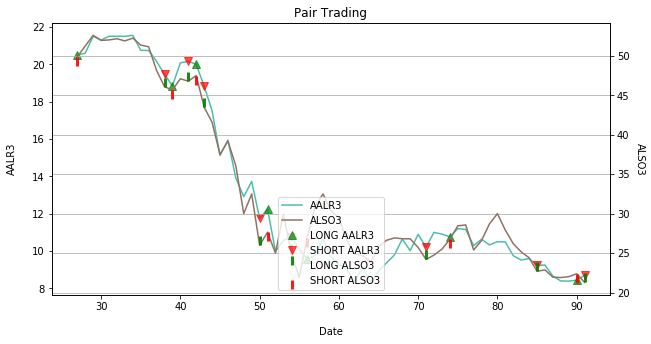

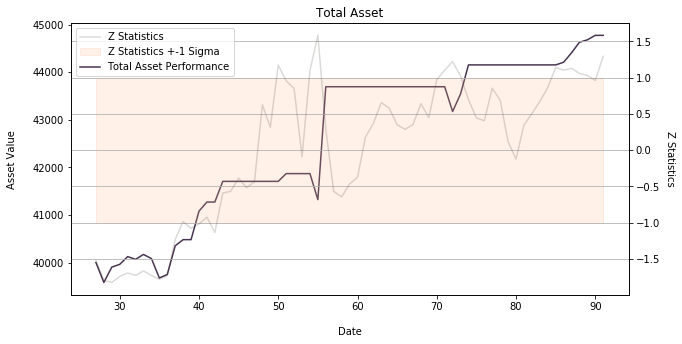

,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2,z,total asset,z upper limit,z lower limit
27,20.49,19014.72,985.28,20000.00,NaN,1.0,49.88,-18954.4,38954.4,20000.0,NaN,-1.0,-1.522403,40000.00,1.0,-1.0
28,20.60,19116.80,985.28,20102.08,5.104000e-03,0.0,51.25,-19475.0,38954.4,19479.4,-0.026030,0.0,-1.798781,39581.48,1.0,-1.0
29,21.50,19952.00,985.28,20937.28,4.154794e-02,0.0,52.60,-19988.0,38954.4,18966.4,-0.026336,0.0,-1.824726,39903.68,1.0,-1.0
30,21.30,19766.40,985.28,20751.68,-8.864571e-03,0.0,51.96,-19744.8,38954.4,19209.6,0.012823,0.0,-1.741873,39961.28,1.0,-1.0
31,21.50,19952.00,985.28,20937.28,8.943854e-03,0.0,52.02,-19767.6,38954.4,19186.8,-0.001187,0.0,-1.693224,40124.08,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,8.66,-8036.48,27850.88,19814.40,2.841768e-02,0.0,21.95,8341.0,16249.4,24590.4,-0.014018,0.0,1.127851,44404.80,1.0,-1.0
88,8.40,-7795.20,27850.88,20055.68,1.217700e-02,0.0,21.90,8322.0,16249.4,24571.4,-0.000773,0.0,1.058259,44627.08,1.0,-1.0
89,8.39,-7785.92,27850.88,20064.96,4.627118e-04,0.0,22.01,8363.8,16249.4,24613.2,0.001701,0.0,1.030206,44678.16,1.0,-1.0
90,8.44,0.00,20018.56,20018.56,-2.312489e-03,1.0,22.38,0.0,24753.8,24753.8,0.005712,-1.0,0.961880,44772.36,1.0,-1.0


In [60]:
signals=signal_generation(df1,df2,cointegration)
plot(signals,'AALR3','ALSO3')
portfolio(signals)